# ANIME RATING

In [1]:
# Import necessary libraries
import numpy as np  # Import NumPy for handling numerical operations
import pandas as pd  # Import Pandas for data manipulation and analysis
import warnings  # Import Warnings to suppress unnecessary warnings

# Suppress warning messages
warnings.filterwarnings("ignore")

# Import SHAP for interpreting model predictions
import shap

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import CatBoostRegressor for building a regression model
from catboost import Pool, CatBoostRegressor

# Import mean_squared_error for evaluating model performance
from sklearn.metrics import mean_squared_error

# Import train_test_split for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Import CountVectorizer from sklearn.feature_extraction.text for text feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# Import ast and re for working with text and regular expressions
import ast
import re
import seaborn as sns

# Set Pandas options to display a maximum of 1000 rows
pd.set_option('display.max_rows', 1000)

## Read the data

In [2]:
# Set Pandas options to display a maximum of 1000 rows
pd.set_option('display.max_rows', 1000)
# read the data
data_anime = pd.read_csv('/Users/megavishy/Downloads/anime.csv')

In [3]:
# Exclude records with undefined rating
data_anime = data_anime[~data_anime['Rating'].isnull()]

# Select only specific columns of interest
selected_cols = ['Rating', 'Type', 'Episodes', 'Studio',
       'Release_season', 'Tags', 'Release_year',
       'Content_Warning', 'staff']
data_anime = data_anime[selected_cols]

print(data_anime.shape)  # Prints the dimensions (rows and columns) of the filtered DataFrame
 # Displays a random sample of 5 rows transposed for better visibility

(15364, 9)


In [4]:
data_anime.dtypes

Rating             float64
Type                object
Episodes           float64
Studio              object
Release_season      object
Tags                object
Release_year       float64
Content_Warning     object
staff               object
dtype: object

In [5]:
data_anime.columns

Index(['Rating', 'Type', 'Episodes', 'Studio', 'Release_season', 'Tags',
       'Release_year', 'Content_Warning', 'staff'],
      dtype='object')

In [6]:
data_anime.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,15364.0,3.355133,0.400624,0.96,3.13,3.36,3.59,4.6
Episodes,8255.0,19.407995,35.741198,1.00,2.00,12.00,25.00,773.0
Release_year,15344.0,2006.537604,14.574175,1907.00,2001.00,2011.00,2016.00,2022.0


## Data preprocessing

In [7]:
data_anime.duplicated().sum()

87

In [8]:
data_anime = data_anime.drop_duplicates()

In [9]:
#verify
data_anime.duplicated().sum()

0

In [10]:
for columns in data_anime.columns:
    print(f"\n unique values in {columns}:")
    print(data_anime[columns])


 unique values in Rating:
0        4.60
1        4.60
2        4.58
3        4.58
4        4.57
         ... 
15365    1.19
15366    1.11
15367    1.06
15368    0.96
17355    3.49
Name: Rating, Length: 15277, dtype: float64

 unique values in Type:
0        TV   
1        TV   
2        Web  
3        TV   
4        TV   
         ...  
15365    Movie
15366    OVA  
15367    Movie
15368    OVA  
17355    Web  
Name: Type, Length: 15277, dtype: object

 unique values in Episodes:
0         NaN
1        13.0
2        12.0
3        64.0
4        10.0
         ... 
15365     NaN
15366     1.0
15367     NaN
15368     1.0
17355     1.0
Name: Episodes, Length: 15277, dtype: float64

 unique values in Studio:
0                 ufotable
1        TMS Entertainment
2         B.C MAY PICTURES
3                    Bones
4               WIT Studio
               ...        
15365                  NaN
15366            Wao World
15367                  NaN
15368         Idea Factory
17355             

In [11]:
print("\n null values:")
print(data_anime.isnull().sum())


 null values:
Rating                 0
Type                   0
Episodes            7055
Studio              4327
Release_season     11294
Tags                 353
Release_year          20
Content_Warning    13470
staff               3521
dtype: int64


In [12]:
for columns in data_anime.columns:
    null_count = data_anime[columns].isnull().sum()
    if null_count > 0:
        print(f"\n {columns}")
        print(f"\n null count {null_count}")
        print(f"\n null percentage {(null_count/len(data_anime))*100:.2f}%")

data_anime[f"{columns}_null_flag"] = data_anime[columns].isnull()
if data_anime[columns].dtype in ['float64', 'int64']:
    data_anime[columns] = data_anime[columns].fillna(data_anime[columns].mean())
else:
    data_anime[columns] = data_anime[columns].fillna(data_anime[columns].mode()[0])


 Episodes

 null count 7055

 null percentage 46.18%

 Studio

 null count 4327

 null percentage 28.32%

 Release_season

 null count 11294

 null percentage 73.93%

 Tags

 null count 353

 null percentage 2.31%

 Release_year

 null count 20

 null percentage 0.13%

 Content_Warning

 null count 13470

 null percentage 88.17%

 staff

 null count 3521

 null percentage 23.05%


## Visualization

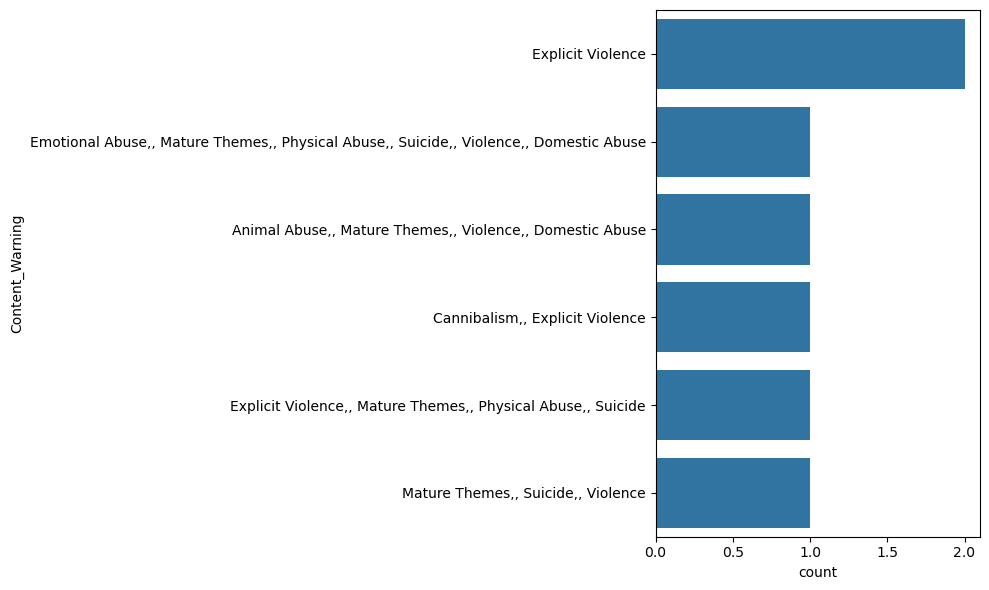

In [13]:
plt.figure(figsize = (10,6))
sns.countplot(data_anime['Content_Warning'].head(10))
plt.tight_layout()
plt.show()

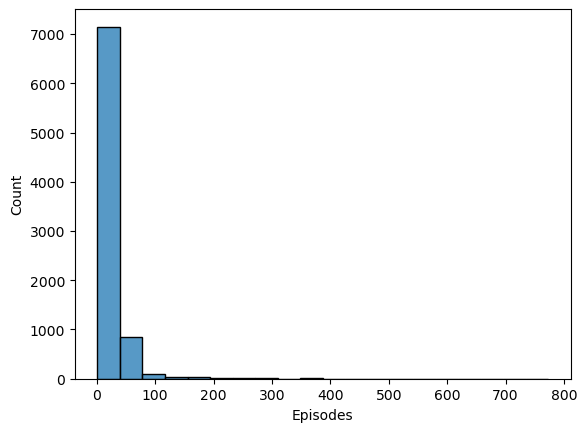

In [14]:
sns.histplot(data_anime['Episodes'], kde = False, bins = 20)
plt.show()

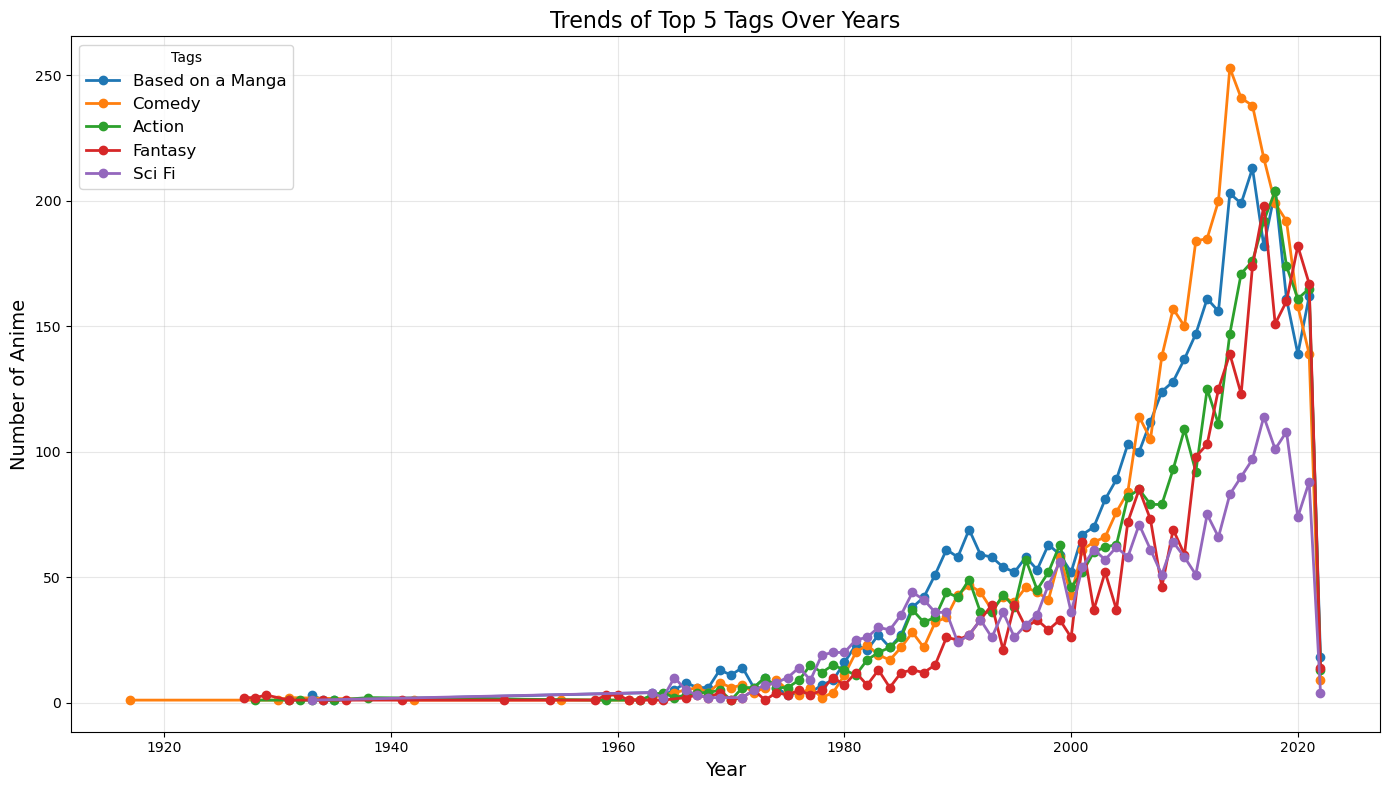

In [15]:
# 3. Line chart showing Tags trends over years
# First, we need to extract tags (assuming Tags is a string with multiple tags)
import pandas as pd

# Create empty list to store year and tag data
tag_trends = []

# Process each row
for _, row in data_anime.iterrows():
    year = row['Release_year']
    # Split tags and process each one
    # Assuming tags are comma-separated
    if isinstance(row['Tags'], str):  # Check if Tags is a string
        tags = [tag.strip() for tag in row['Tags'].split(',')]
        for tag in tags:
            tag_trends.append({'Year': year, 'Tag': tag})

# Convert to DataFrame
tag_df = pd.DataFrame(tag_trends)

# Get top 5 most common tags
top_tags = tag_df['Tag'].value_counts().nlargest(5).index

# Filter for these tags
filtered_tags = tag_df[tag_df['Tag'].isin(top_tags)]

# Count occurrences by year and tag
tag_counts = filtered_tags.groupby(['Year', 'Tag']).size().reset_index(name='Count')

# Create the line chart
plt.figure(figsize=(14, 8))
# For each tag, plot its trend
for tag in top_tags:
    tag_data = tag_counts[tag_counts['Tag'] == tag]
    plt.plot(tag_data['Year'], tag_data['Count'], marker='o', linewidth=2, label=tag)

plt.title('Trends of Top 5 Tags Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Anime', fontsize=14)
plt.legend(title='Tags', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


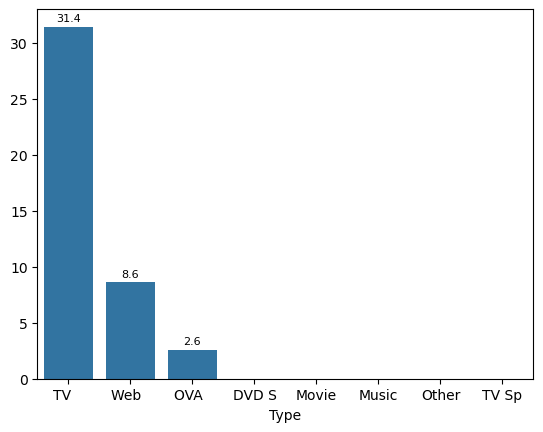

In [16]:
#Grouped bar chart of average Episodes by Type
avg_episode = data_anime.groupby('Type')['Episodes'].mean().sort_values(ascending=False)

sns.barplot(x = avg_episode.index, y = avg_episode.values)
for i,v in enumerate(avg_episode):
    plt.text(i, v+ 0.5,f'{v:.1f}', ha='center', fontsize=8)
plt.show()

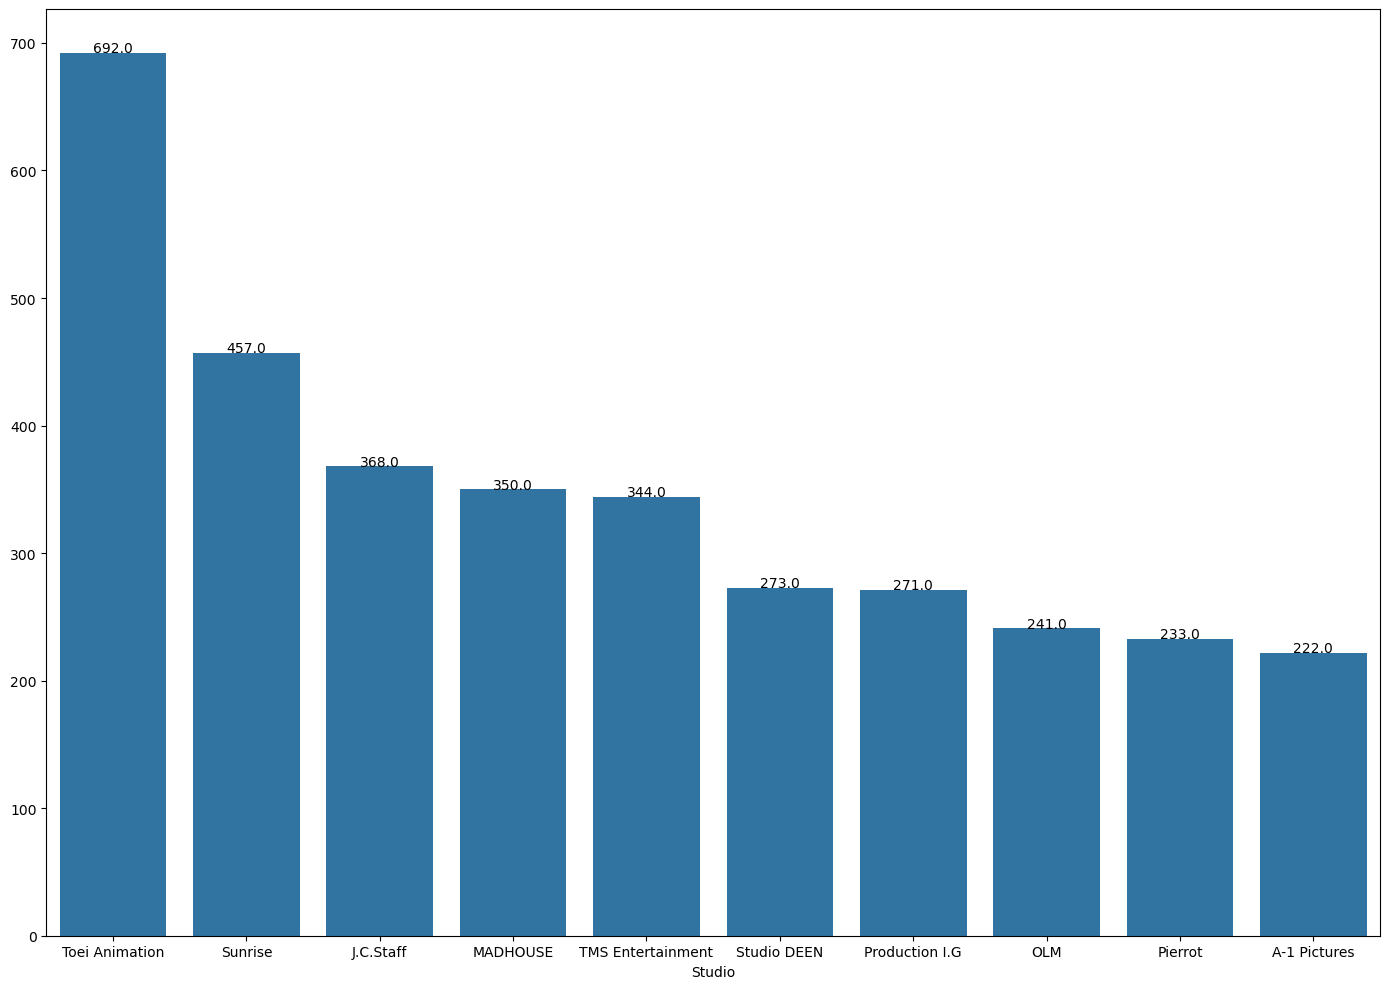

In [17]:
# top 10 studio names with number of productions

studio_name = data_anime['Studio'].value_counts().nlargest(10)

plt.figure(figsize = (14,10))
sns.barplot(x = studio_name.index, y = studio_name.values)
for i,v in enumerate(studio_name):
    plt.text(i, v+0.5,f'{v:.1f}', ha='center',fontsize = 10)
plt.tight_layout()
plt.show()

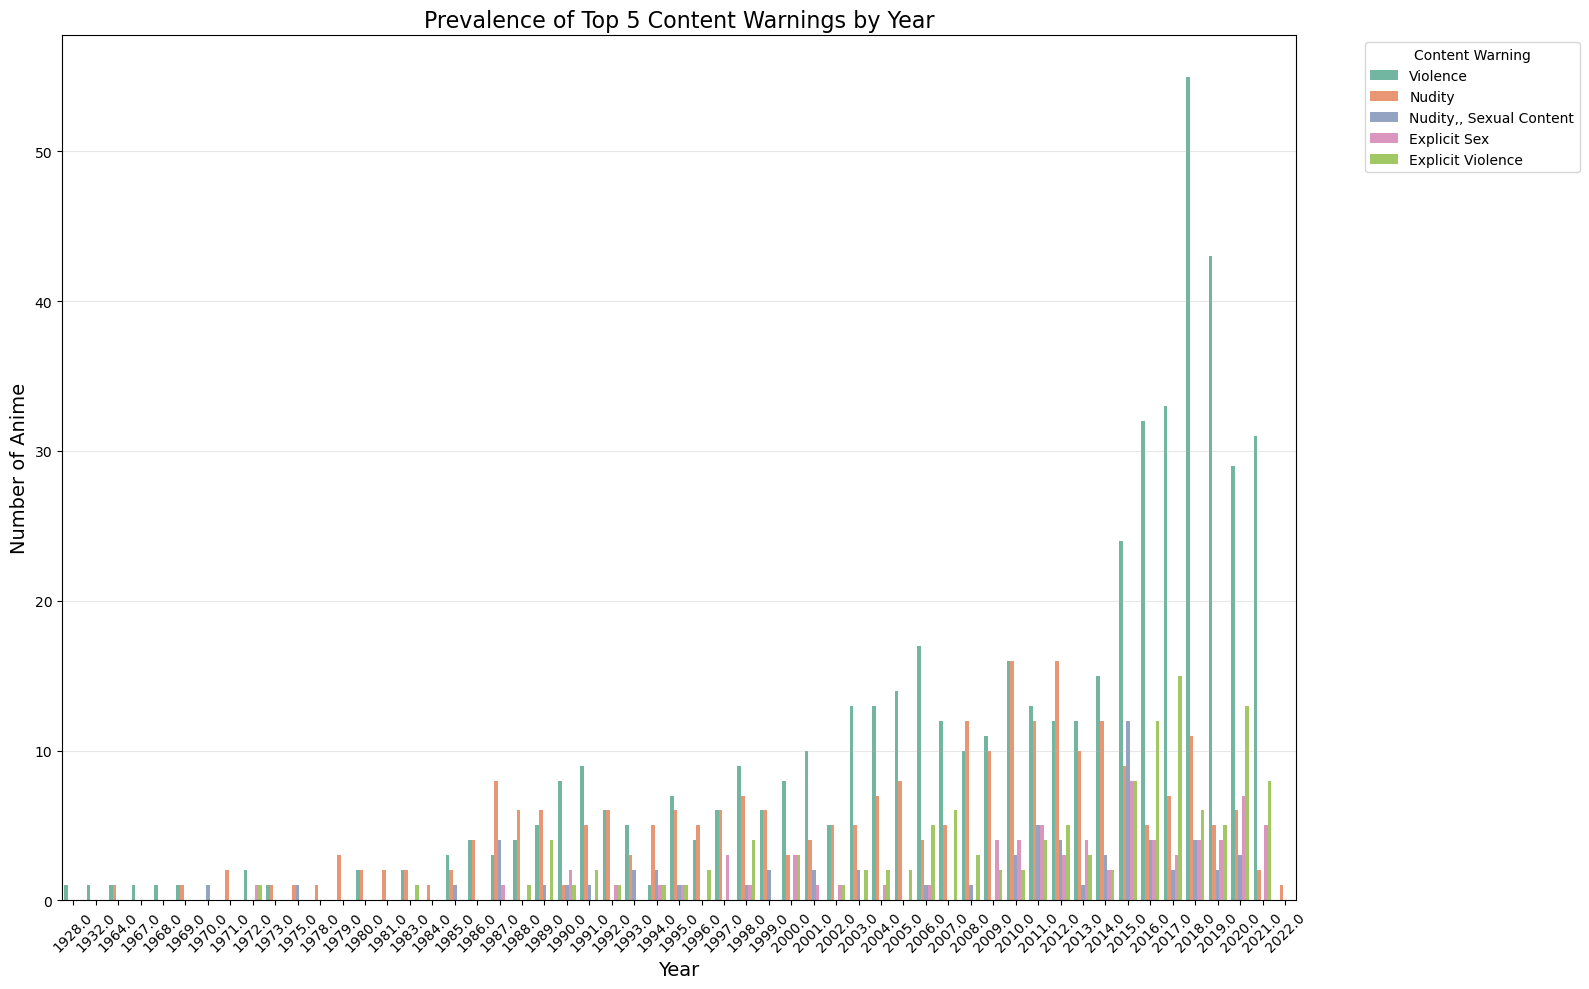

In [18]:
# 4. Content warnings by year as bar chart
plt.figure(figsize=(16, 10))


# Group by year and content warning, then count
warning_counts = data_anime.groupby(['Release_year', 'Content_Warning']).size().reset_index(name='Count')

# Get top 5 most common content warnings
top_warnings = data_anime['Content_Warning'].value_counts().nlargest(5).index
filtered_warnings = warning_counts[warning_counts['Content_Warning'].isin(top_warnings)]

# Create a grouped bar chart
sns.barplot(x='Release_year', y='Count', hue='Content_Warning', data=filtered_warnings, palette='Set2')

# Add labels and title
plt.title('Prevalence of Top 5 Content Warnings by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Anime', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Improve legend placement
plt.legend(title='Content Warning', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

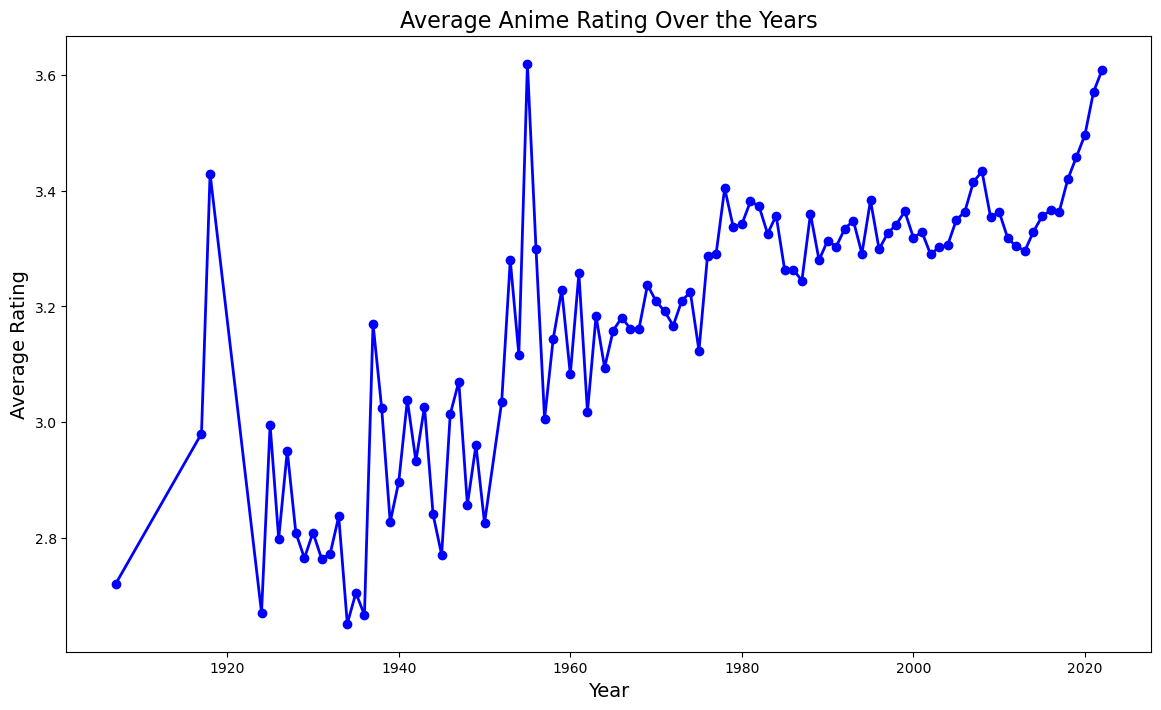

In [19]:
# Check average rating change over years
plt.figure(figsize=(14, 8))

# Group by year and calculate average rating
avg_rating_by_year = data_anime.groupby('Release_year')['Rating'].mean().reset_index()

# Create the line chart
plt.plot(avg_rating_by_year['Release_year'], avg_rating_by_year['Rating'], marker='o', linewidth=2, color='blue')
# Add labels and title
plt.title('Average Anime Rating Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.show()

## Rare Label Encoder

In [20]:
data_anime.columns

Index(['Rating', 'Type', 'Episodes', 'Studio', 'Release_season', 'Tags',
       'Release_year', 'Content_Warning', 'staff', 'staff_null_flag'],
      dtype='object')

In [21]:
categorical_columns = data_anime.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", list(categorical_columns))

Categorical columns: ['Type', 'Studio', 'Release_season', 'Tags', 'Content_Warning', 'staff']


In [22]:

# List of categorical columns to process
categorical_cols = ['Type', 'Studio', 'Release_season', 'Tags', 'Content_Warning', 'staff']

# Create a copy of the DataFrame to avoid modifying the original
anime_encoded = data_anime.copy()

# Process each categorical column
for column in categorical_cols:
    # Skip if column is not in DataFrame
    if column not in data_anime.columns:
        print(f"Column '{column}' not found in the DataFrame. Skipping.")
        continue
        
    # Fill NaN values and convert to string
    anime_encoded[column] = anime_encoded[column].fillna('Missing').astype(str)
    
    # Count occurrences of each category
    value_counts = anime_encoded[column].value_counts()
    
    # Set the minimum count threshold
    min_count = 15
    
    # Identify rare categories (those appearing less than min_count times)
    rare_categories = value_counts[value_counts < min_count].index.tolist()
    
    # Replace rare categories with 'Other'
    if rare_categories:
        # Create a mapping dictionary for faster replacement
        mapping = {cat: 'Other' for cat in rare_categories}
        
        # Apply the mapping using replace method
        anime_encoded[column] = anime_encoded[column].replace(mapping)
    
    # Print summary of changes
    print(f"Column '{column}': Replaced {len(rare_categories)} rare categories with 'Other'")

# Check the result
print("\nUnique values in encoded columns:")
for column in categorical_cols:
    if column in data_anime.columns:
        print(f"{column}: {anime_encoded[column].nunique()} (was {data_anime[column].nunique()} before encoding)")

Column 'Type': Replaced 0 rare categories with 'Other'
Column 'Studio': Replaced 561 rare categories with 'Other'
Column 'Release_season': Replaced 0 rare categories with 'Other'
Column 'Tags': Replaced 10434 rare categories with 'Other'
Column 'Content_Warning': Replaced 196 rare categories with 'Other'
Column 'staff': Replaced 9704 rare categories with 'Other'

Unique values in encoded columns:
Type: 8 (was 8 before encoding)
Studio: 130 (was 689 before encoding)
Release_season: 5 (was 4 before encoding)
Tags: 41 (was 10473 before encoding)
staff: 24 (was 9727 before encoding)


In [23]:
import numpy as np # Set the target variable (what we want to predict)
label = 'Rating'
df = anime_encoded
# Extract the target variable and features from the DataFrame
y = df[label].values.reshape(-1,)  # Target variable (salaries)
X = df.drop([label], axis=1)       # Features (everything else)

# Identify categorical columns in the feature set
cat_cols = X.select_dtypes(include=['object']).columns

# Get the indices of categorical columns in the feature set
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5, 
    random_state=0, 
    #stratify=df[['residence_location']]
)

# Print the shapes of the training and testing sets to verify the split
print("Training set shapes - X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
print("Testing set shapes - X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))

Training set shapes - X_train: (7638, 9), y_train: (7638,)
Testing set shapes - X_test: (7639, 9), y_test: (7639,)


In [24]:
# Import necessary libraries
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
import numpy as np

# Create data pools with categorical features
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_cols_idx)

# Initialize and configure model
model = CatBoostRegressor(
    iterations=10000,
    depth=5,
    learning_rate=0.008,
    loss_function='RMSE',
    early_stopping_rounds=100,
    verbose=0
)

# Train model
model.fit(train_pool, eval_set=test_pool)

# Make predictions
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Calculate error metrics
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Print results
print(f"RMSE score - Train: {rmse_train:.1f}, Test: {rmse_test:.1f}")

# Baseline scores (assuming the same prediction for all data samples)
# Calculating RMSE for training and test sets using mean value prediction
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)] * len(y_test), squared=False)

# Print baseline results
print(f"RMSE baseline score - Train: {rmse_bs_train:.1f}, Test: {rmse_bs_test:.1f}")

# Calculate improvement over baseline
train_improvement = (rmse_bs_train - rmse_train) / rmse_bs_train * 100
test_improvement = (rmse_bs_test - rmse_test) / rmse_bs_test * 100
print(f"Model improvement over baseline - Train: {train_improvement:.1f}%, Test: {test_improvement:.1f}%")

RMSE score - Train: 0.3, Test: 0.3
RMSE baseline score - Train: 0.4, Test: 0.4
Model improvement over baseline - Train: 24.9%, Test: 19.0%


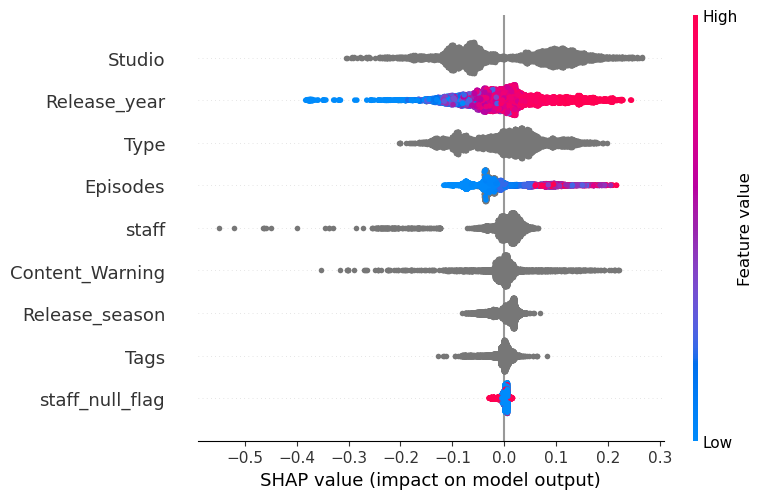

In [25]:
%matplotlib inline
# Initialize the SHAP JavaScript visualization library
shap.initjs()

# Create a SHAP TreeExplainer for the given 'model'
ex = shap.TreeExplainer(model)

# Compute SHAP values for the test dataset 'X_test' using the TreeExplainer
shap_values = ex.shap_values(X_test)

# Generate a summary plot of SHAP values to visualize feature contributions
shap.summary_plot(shap_values, X_test)

In [26]:
# Calculate the expected values using a variable named 'ex.expected_value'.
expected_values = ex.expected_value

# Print the average predicted label
print(f"Average predicted rating is {round(expected_values, 3)} points")

# Print the average actual label from 'y_test'
print(f"Average actual rating is {round(np.mean(y_test), 3)} points")

Average predicted rating is 3.36 points
Average actual rating is 3.352 points



MODEL EVALUATION:
Train RMSE: 0.3038 | Test RMSE: 0.3143
Test improvement: 21.29% | Best iteration: 8125

TOP 5 FEATURES:
           Feature  Importance
2           Studio   26.898664
5     Release_year   23.158038
0             Type   14.309784
1         Episodes   11.818980
6  Content_Warning    9.032584


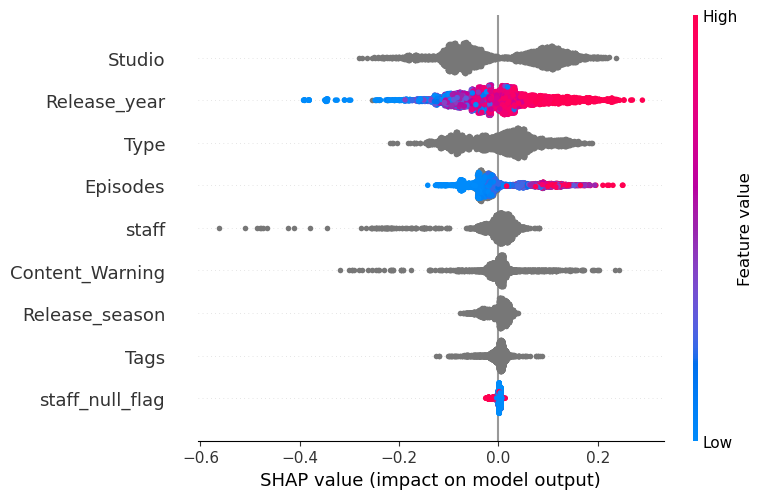

<Figure size 640x480 with 0 Axes>


FINAL METRICS:
R² Train: 0.4294 | R² Test: 0.3803


In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
##################################################
# DATA PREPROCESSING
##################################################
# Processing categorical columns
min_count = 5  # Minimum count threshold for categories
for column in categorical_cols:
    df[column] = df[column].fillna('Missing').astype(str)
    value_counts = df[column].value_counts()
    rare_categories = value_counts[value_counts < min_count].index.tolist()
    mapping = {cat: 'Other' for cat in rare_categories}
    df[column] = df[column].replace(mapping)

##################################################
# DATA EXPLORATION
##################################################
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]  # Get indices

##################################################
# MODEL TRAINING
##################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# Create Pool objects
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_cols_idx)

# Initialize model
model = CatBoostRegressor(
    iterations=10000,
    depth=5,
    learning_rate=0.008,
    loss_function='RMSE',
    early_stopping_rounds=100,
    verbose=0
)

# Train model
model.fit(train_pool, eval_set=test_pool)

##################################################
# MODEL EVALUATION
##################################################
# Generate predictions
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Calculate RMSE
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate baseline metrics
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)] * len(y_test), squared=False)

# Calculate improvement percentage
train_improvement = (rmse_bs_train - rmse_train) / rmse_bs_train * 100
test_improvement = (rmse_bs_test - rmse_test) / rmse_bs_test * 100

# Print core metrics
print("\nMODEL EVALUATION:")
print(f"Train RMSE: {rmse_train:.4f} | Test RMSE: {rmse_test:.4f}")
print(f"Test improvement: {test_improvement:.2f}% | Best iteration: {model.get_best_iteration()}")

# Feature importance (overall)
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
print("\nTOP 5 FEATURES:")
print(importance_df.head(5))


##################################################
# SHAP ANALYSIS
##################################################
# Create explainer
ex = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = ex.shap_values(X_test)

# Create summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, max_display=10)
plt.tight_layout()
plt.show()

# Model performance metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"\nFINAL METRICS:")
print(f"R² Train: {r2_train:.4f} | R² Test: {r2_test:.4f}")

In [34]:
# if consuoj mayrix 

In [ ]:
# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Calculate baseline accuracy (most frequent class)
baseline_acc = max(y_train.value_counts()) / len(y_train)

# Calculate improvement percentage
accuracy_improvement = (accuracy_test - baseline_acc) / baseline_acc * 100

# Print core metrics
print("\nMODEL EVALUATION:")
print(f"Train Accuracy: {accuracy_train:.4f} | Test Accuracy: {accuracy_test:.4f}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")
print(f"Accuracy improvement: {accuracy_improvement:.2f}% | Best iteration: {model.get_best_iteration()}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_test_pred))
